# Environment preparation

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from random import sample
import seaborn as sns
import datetime
from tqdm.notebook import tqdm
from pandas.api.types import CategoricalDtype

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

import CHAID
pd.set_option('mode.chained_assignment',None)


from pathlib import Path
pd.options.display.max_columns=200
pd.options.display.max_rows=200

In [2]:
#Loading data
data_file = Path("./Data/2023_DS2_HW1_data_train.csv")
data = pd.read_csv(data_file, encoding='utf-8', sep = ',', decimal = '.', index_col = 'Booking_ID')

print(f'Number of rows:      {data.shape[0]}') #32647 observations
print(f'Number of columns:   {data.shape[1]}') #17 possible predictors + 1 target variable

Number of rows:      32647
Number of columns:   18


# Data exploration

In [3]:
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0


In [4]:
data.describe().transpose() # counting predictor are all non-negative
data.isna().sum() # xgboost handles NaNs automatically

no_of_adults                             4416
no_of_children                          27604
no_of_weekend_nights                    24918
no_of_week_nights                        8360
type_of_meal_plan                       16103
required_car_parking_space              14784
room_type_reserved                      21287
lead_time                               25712
arrival_year                             2993
arrival_month                             907
arrival_date                            27190
market_segment_type                     14121
repeated_guest                          24978
no_of_previous_cancellations               69
no_of_previous_bookings_not_canceled    14621
avg_price_per_room                      23589
no_of_special_requests                   7450
booking_status                            352
dtype: int64

In [5]:
data.dtypes

no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
type_of_meal_plan                        object
required_car_parking_space              float64
room_type_reserved                       object
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
market_segment_type                      object
repeated_guest                          float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
booking_status                          float64
dtype: object

# Metadata

In [6]:
col_target = 'booking_status' #define target
data[col_target].value_counts(dropna=False) # NaNs

0.0    21774
1.0    10521
NaN      352
Name: booking_status, dtype: int64

In [7]:
tobedropped=list(data.loc[data[col_target].isnull()==True].index) # unique rows with NaNs
data.drop(labels=tobedropped,axis=0,inplace=True) # deleting those rows

In [58]:
import sklearn
print(sklearn.__version__)

1.2.1


In [8]:
#define datetime objects
col_year = "arrival_year"
col_month = "arrival_month"
col_date = "arrival_date"
data[col_year]=data[col_year].astype(object)
data[col_month]=data[col_month].astype(object)
data[col_date]=data[col_date].astype(object)

In [9]:
cols_pred = list(data.columns)[0:-1] #define predictors
cols_pred_num=list(col for col in cols_pred if data[col].dtype!="O") #numerical
cols_pred_cat=list(col for col in cols_pred if data[col].dtype=="O") #categorical

# Moving 0/1 variables
cols_pred_num.remove("repeated_guest")
cols_pred_num.remove("required_car_parking_space")

cols_pred_cat.append("repeated_guest")
cols_pred_cat.append("required_car_parking_space")

# Split data

In [10]:
#splitting with stratification by month
data['sample']='default'
col_sample='sample'
month_mask=data[col_month].isna()==False

data_train, data_rest = train_test_split(data[month_mask], test_size=0.4, random_state=12, 
                                         stratify=(data[month_mask][[col_month,col_target]]))
data_valid, data_test = train_test_split(data_rest, train_size=0.5, stratify = (data_rest[[col_month,col_target]]),
                                         random_state=12)

data.loc[data_train.index, 'sample'] = 'train'
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

In [11]:
#define masks
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid') 
test_mask = (data['sample'] == 'test') 
oot_mask = (data['sample'] == 'oot')  
hoot_mask = (data['sample'] == 'hoot')

In [12]:
cols_with_inf=[]
cols_with_neginf=[]
for col in cols_pred_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(cols_with_inf)       
for col in cols_pred_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(col_with_neginf)
#no infinities

# Mean target encoding

In [13]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_cr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_cr = (target, np.mean),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_cr'] + alpha * total_cr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [14]:
total_cr = np.mean(data[train_mask][col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_cr

        data['MTE_' + pred] = data[pred].replace(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/8 [00:00<?, ?it/s]

# XGBoost

C:\Users\Karla\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


--------------------------------------------
The Best AUC on Valid:
0.79725066140523

Iteration for the Best Score
99


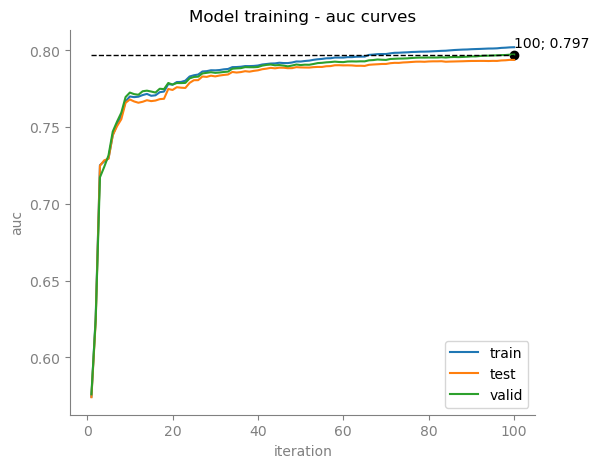

In [31]:
model=xgb.XGBClassifier(
    booster="gbtree",
    objective="binary:logistic",
    eval_metric="auc",
    verbosity=1,
    random_state=12,
    importance_type="total_gain",
    max_depth=3,
    learning_rate=0.1,
    subsample=0.6,
    colsample_bytree=0.5
)

model.fit(
    data[train_mask][cols_pred].values,
    data[train_mask][col_target].values,
    eval_set=[   
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values) #použitá pro early_stopping
    ],
    verbose = False,
    early_stopping_rounds = 30,
)

evals_result=model.evals_result()
evals_result["train"]=evals_result.pop("validation_0")
evals_result["test"]=evals_result.pop("validation_1")
evals_result["valid"]=evals_result.pop("validation_2")
print("--------------------------------------------")
print("The Best AUC on Valid:")
print(model.best_score)
print("")
print("Iteration for the Best Score")
print(model.best_iteration)
data["predicted_cr"]=model.predict_proba(data[cols_pred])[:,1]
data["predicted_score"]=np.log(data["predicted_cr"]/(1-data["predicted_cr"]))

# Plot AUC 

metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = model.best_score
best_iteration = model.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

Variable: no_of_special_requests    Importance: 0.24887000024318695
Variable: MTE_arrival_month         Importance: 0.19235000014305115
Variable: lead_time                 Importance: 0.1594099998474121
Variable: MTE_arrival_year          Importance: 0.1252399981021881
Variable: MTE_market_segment_type   Importance: 0.07659000158309937
Variable: avg_price_per_room        Importance: 0.04510999843478203
Variable: no_of_adults              Importance: 0.03756999969482422
Variable: no_of_week_nights         Importance: 0.03629999980330467
Variable: MTE_type_of_meal_plan     Importance: 0.024890000000596046
Variable: no_of_previous_bookings_not_canceled Importance: 0.016860000789165497
Variable: MTE_required_car_parking_space Importance: 0.013609999790787697
Variable: MTE_arrival_date          Importance: 0.01228999998420477
Variable: no_of_weekend_nights      Importance: 0.005410000216215849
Variable: MTE_room_type_reserved    Importance: 0.0034099998883903027
Variable: MTE_repeated_guest

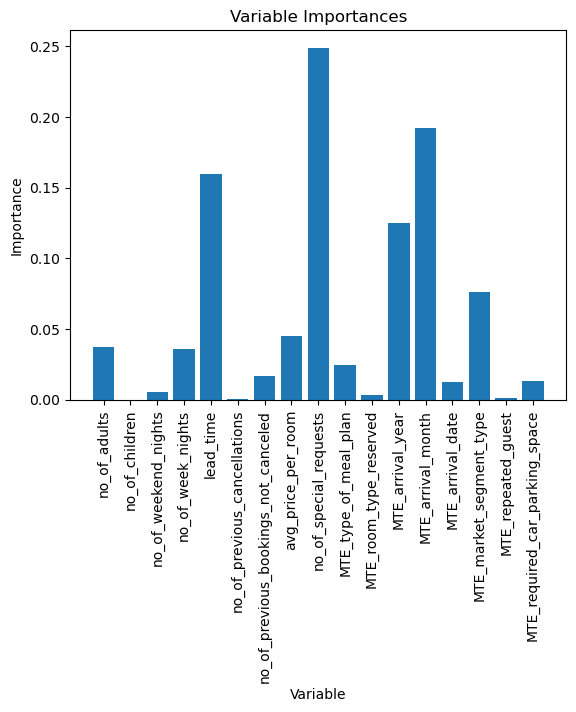

In [32]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(cols_pred, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:25} Importance: {}'.format(*pair)) for pair in feature_importances];

# Plot importance
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, cols_pred, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [33]:
# Creating a matrix containg Feature importance = total gain and the name of an according predictor
FI=model.feature_importances_
FI=[FI,np.array(cols_pred)]
FI=pd.DataFrame(FI).transpose()
FI.columns=["Feature importance","Predictor"]
FI=FI.sort_values(by=["Feature importance"],ascending=True)
FI

,Feature importance,Predictor
1,0.000228,no_of_children
5,0.000826,no_of_previous_cancellations
15,0.001024,MTE_repeated_guest
10,0.003408,MTE_room_type_reserved
2,0.005415,no_of_weekend_nights
13,0.012293,MTE_arrival_date
16,0.013608,MTE_required_car_parking_space
6,0.016863,no_of_previous_bookings_not_canceled
9,0.024885,MTE_type_of_meal_plan
3,0.036299,no_of_week_nights


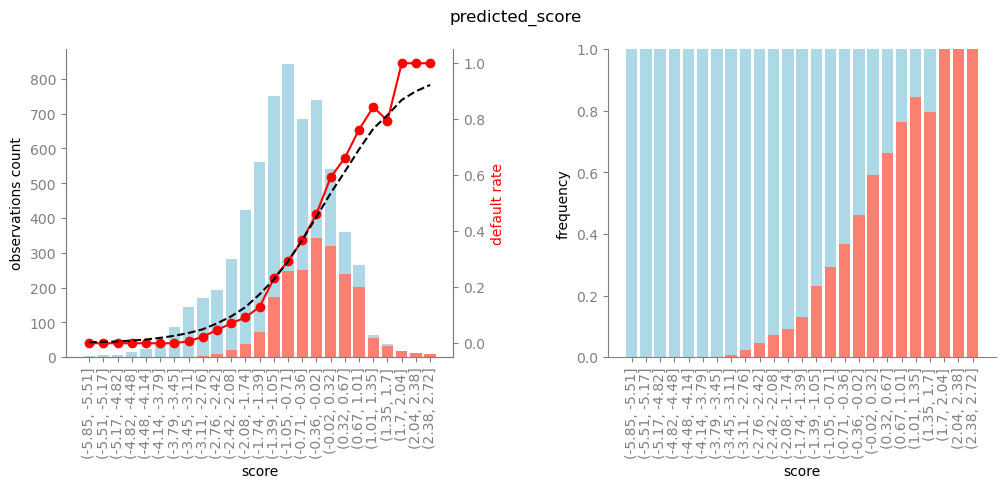

In [34]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt = dt.assign(score_bin = pd.cut(dt[col_score], bins = bins, include_lowest = False))
    
    dt_grp = dt.groupby('score_bin').agg(
        bad_cnt = (col_target, sum),
        tot_cnt = (col_target, len),
        def_rt = (col_target, np.mean),
        avg_score = (col_score, np.mean)
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count')
    axs[0].set_xlabel('score')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray')
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray')
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'], color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency')
    axs[1].set_xlabel('score')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')
plot_score_calibration(data[test_mask],"predicted_score",col_target)

In [35]:
def fit_model(predictors):
    params={
        'eta': 0.15,
        'max_depth': 3,
        "subsample":0.7,
        "colsample_bytree":0.7,

        'eval_metric': 'auc',
        'objective': 'binary:logistic' ,
        'booster': 'gbtree',
        'tree_method': 'hist',

        'base_score': 0.08,

        'seed': 12
    }

    evals_result = {}

    booster_mc = xgb.train(
        verbose_eval=False,
        params = params,
        dtrain = xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]), 'train'),
            (xgb.DMatrix(data[test_mask][predictors], data[test_mask][col_target]), 'test'),
            (xgb.DMatrix(data[valid_mask][predictors], data[valid_mask][col_target]), 'valid')
        ),
        evals_result = evals_result,
        early_stopping_rounds = 30
    )
    
    
    prediction = booster_mc.predict(xgb.DMatrix(data[test_mask][predictors]))
    return roc_auc_score(data[test_mask][col_target], prediction)

prediction=model.predict_proba(data[test_mask][cols_pred],iteration_range=(0,model.best_iteration))[:,1]
auc_base = roc_auc_score(data[test_mask][col_target], prediction)

marginal_contribution = []
for pred in tqdm(cols_pred):
    auc = fit_model(predictors=[p for p in cols_pred if p != pred])
    marginal_contribution.append((pred, auc_base - auc))
    
marginal_contribution = sorted(marginal_contribution, key=lambda x: x[1], reverse=False)
marginal_contribution

  0%|          | 0/17 [00:00<?, ?it/s]

[('no_of_previous_cancellations', -0.014439226032913366),
 ('no_of_children', -0.014140458341391882),
 ('MTE_room_type_reserved', -0.012707585812720357),
 ('MTE_repeated_guest', -0.012289541976139073),
 ('no_of_weekend_nights', -0.01193944974785166),
 ('MTE_arrival_date', -0.01113702034795594),
 ('no_of_previous_bookings_not_canceled', -0.010742762460922095),
 ('MTE_required_car_parking_space', -0.009952226035800149),
 ('MTE_type_of_meal_plan', -0.008891384232571187),
 ('no_of_week_nights', -0.007007964251796173),
 ('no_of_adults', -0.006755209671413187),
 ('avg_price_per_room', -0.0058318298727279005),
 ('MTE_market_segment_type', -0.0013029157994705054),
 ('lead_time', 0.0036486607413480643),
 ('MTE_arrival_year', 0.01065518167096291),
 ('MTE_arrival_month', 0.021238890027509782),
 ('no_of_special_requests', 0.06317040150336428)]

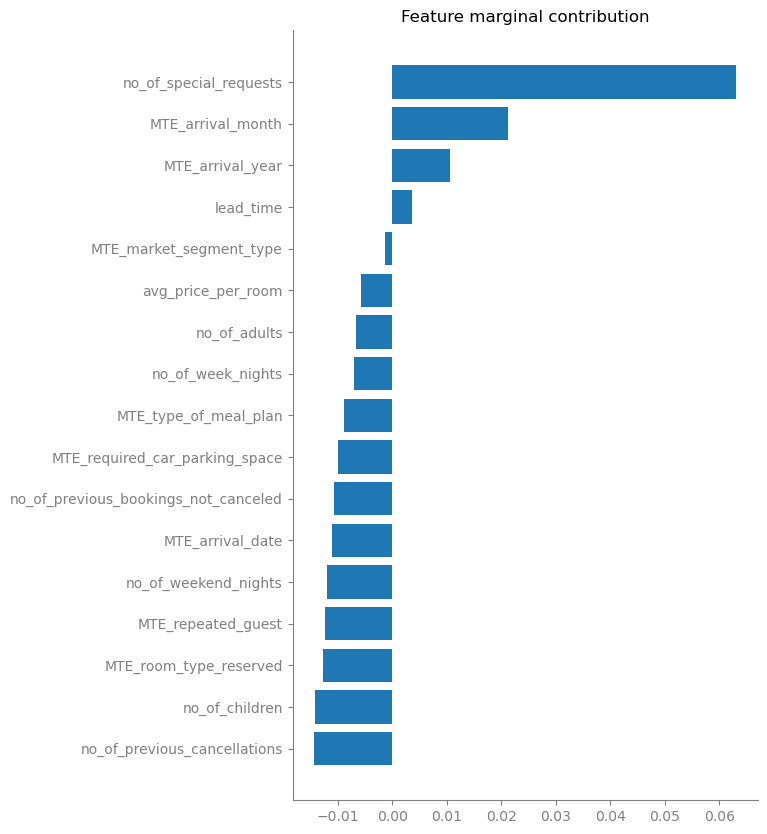

In [36]:
plt.figure(figsize=(6,10))
ax = plt.subplot(1,1,1)
ax.barh(range(len(marginal_contribution)), [imp for p, imp in marginal_contribution])
ax.set_yticks(range(len(marginal_contribution)))
ax.set_yticklabels([p for p, imp in marginal_contribution])

ax.set_title('Feature marginal contribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

plt.show()

In [37]:
MC=pd.DataFrame(marginal_contribution,columns=["Predictor","Marginal Contribution"])
MC

,Predictor,Marginal Contribution
0,no_of_previous_cancellations,-0.014439
1,no_of_children,-0.014140
2,MTE_room_type_reserved,-0.012708
3,MTE_repeated_guest,-0.012290
4,no_of_weekend_nights,-0.011939
5,MTE_arrival_date,-0.011137
6,no_of_previous_bookings_not_canceled,-0.010743
7,MTE_required_car_parking_space,-0.009952
8,MTE_type_of_meal_plan,-0.008891
9,no_of_week_nights,-0.007008


In [38]:
FI=model.feature_importances_
FI=[FI,np.array(cols_pred)]
FI=pd.DataFrame(FI).transpose()
FI.columns=["Feature importance","Predictor"]
FI=FI.sort_values(by=["Feature importance"],ascending=False)
FI

,Feature importance,Predictor
8,0.248869,no_of_special_requests
12,0.192351,MTE_arrival_month
4,0.159412,lead_time
11,0.125244,MTE_arrival_year
14,0.076594,MTE_market_segment_type
7,0.045112,avg_price_per_room
0,0.037568,no_of_adults
3,0.036299,no_of_week_nights
9,0.024885,MTE_type_of_meal_plan
6,0.016863,no_of_previous_bookings_not_canceled


In [39]:
cols_pred=list(FI.loc[FI["Feature importance"]>0.02,"Predictor"])
cols_pred_num=list(col for col in cols_pred if col.startswith("MTE")==False)
cols_pred_cat=list(col for col in cols_pred if col.startswith("MTE")==True)

C:\Users\Karla\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


--------------------------------------------
The Best AUC on Valid:
0.7983704379905665

Iteration for the Best Score
99


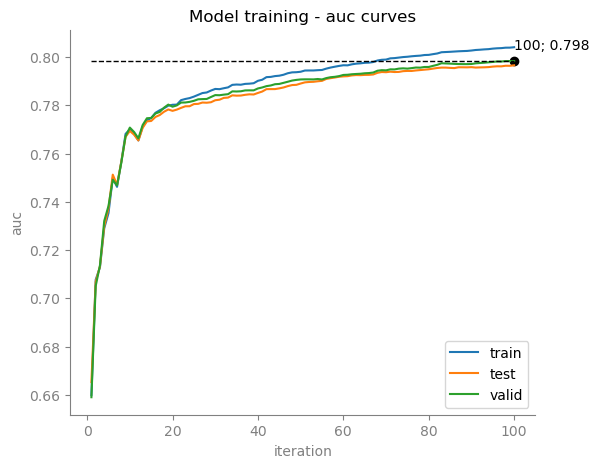

In [49]:
final_model=xgb.XGBClassifier(
    booster="gbtree",
    objective="binary:logistic",
    eval_metric="auc",
    verbosity=1,
    random_state=12,
    importance_type="total_gain",
    max_depth=3,
    learning_rate=0.15,
    subsample=0.6,
    colsample_bytree=0.5
)


final_model.fit(
    data[train_mask][cols_pred].values,
    data[train_mask][col_target].values,
    eval_set=[   
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values) #použitá pro early_stopping
    ],
    verbose = False,
    early_stopping_rounds = 30,
)

evals_result=final_model.evals_result()
evals_result["train"]=evals_result.pop("validation_0")
evals_result["test"]=evals_result.pop("validation_1")
evals_result["valid"]=evals_result.pop("validation_2")
print("--------------------------------------------")
print("The Best AUC on Valid:")
print(final_model.best_score)
print("")
print("Iteration for the Best Score")
print(final_model.best_iteration)
data["predicted_cr"]=final_model.predict_proba(data[cols_pred])[:,1]
data["predicted_score"]=np.log(data["predicted_cr"]/(1-data["predicted_cr"]))

# Plot AUC 

metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = final_model.best_score
best_iteration = final_model.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

In [50]:
data_test_file=Path("./Data/2023_DS2_HW1_data_test.csv")
data_test=pd.read_csv(data_test_file,sep=",",decimal=".",index_col="Booking_ID")

data_test.describe().transpose()
data_test.shape

(3593, 17)

In [51]:
cols_pred_test = list(data_test.columns)

# Numerical and categorial predictors
cols_pred_num_test=list(col for col in cols_pred_test if data_test[col].dtype!="O")
cols_pred_cat_test=list(col for col in cols_pred_test if data_test[col].dtype=="O")

# Moving categorical variables to appropriate cols_pred_test variable

cols_pred_num_test.remove("repeated_guest")
cols_pred_num_test.remove("required_car_parking_space")
cols_pred_num_test.remove(col_year)
cols_pred_num_test.remove(col_month)
cols_pred_num_test.remove(col_date)

cols_pred_cat_test.append("repeated_guest")
cols_pred_cat_test.append("required_car_parking_space")
cols_pred_cat_test.append(col_year)
cols_pred_cat_test.append(col_month)
cols_pred_cat_test.append(col_date)

In [52]:
cols_with_inf=[]
cols_with_neginf=[]
for col in cols_pred_num_test:
    if np.any(np.isinf(data_test[col])):
        cols_with_inf.append(col)
        print(cols_with_inf)       
for col in cols_pred_num_test:
    if np.any(np.isneginf(data_test[col])):
        cols_with_neginf.append(col)
        print(col_with_neginf)

In [53]:
total_dr = np.mean(data[train_mask][col_target])

# Encode categorical predictors Dummy of MTE, alpha is chosen 0.01 based on previous comment
for pred in tqdm(cols_pred_cat_test):
    if len(data_test[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data_test[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data_test[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data_test.columns:
                del data_test[d]
                
        data_test = data_test.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred_test:
                cols_pred_test.append(col)
        
        if pred in cols_pred_test:
            cols_pred_test.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target,
            alpha=0.01
        )

        additional_values = set(data_test[data_test[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        data_test['MTE_' + pred] = data_test[pred].replace(new_vals)
        
        if 'MTE_' + pred not in cols_pred_test:
            cols_pred_test.append('MTE_' + pred)
        
        if pred in cols_pred_test:
            cols_pred_test.remove(pred)
            
# data již obsahují jak původní kategoriální veličiny, tak i upravené MTE a dummy proměnné
# data[cols_pre] obsahjí pouze nové kategoriální veličiny, tedy MTE a dummy, už by měly všechny obsahovat pouze čísla a NaNs

  0%|          | 0/8 [00:00<?, ?it/s]

In [54]:
data_test[cols_pred_test]

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,MTE_type_of_meal_plan,MTE_room_type_reserved,MTE_market_segment_type,MTE_repeated_guest,MTE_required_car_parking_space,MTE_arrival_year,MTE_arrival_month,MTE_arrival_date
Booking_ID,,,,,,,,,,,,,,,,,
INN04969,2.0,NaN,1.0,0.0,NaN,0.0,NaN,NaN,3.0,0.316344,NaN,NaN,NaN,NaN,0.154826,0.384235,0.331601
INN34541,2.0,0.0,NaN,2.0,NaN,0.0,0.0,NaN,NaN,0.316344,NaN,0.302355,NaN,0.329799,0.364822,0.269653,NaN
INN36109,2.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN,NaN,0.316344,NaN,NaN,NaN,0.329799,0.364822,0.151392,NaN
INN01554,2.0,NaN,0.0,3.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.364453,NaN,0.329799,0.364822,0.391516,0.313010
INN24975,2.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,0.329799,0.364822,0.324643,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN29523,1.0,NaN,NaN,2.0,39.0,0.0,NaN,87.00,NaN,0.434264,0.324120,0.302355,NaN,0.329799,0.154826,0.384235,NaN
INN25061,2.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0.325052,NaN,0.364453,0.335158,0.329799,0.364822,0.391516,NaN
INN08475,2.0,NaN,NaN,NaN,308.0,0.0,0.0,78.30,NaN,NaN,NaN,0.364453,NaN,NaN,0.364822,0.294038,NaN


In [55]:
cols_pred_test=list(FI.loc[FI["Feature importance"]>0.02,"Predictor"])
cols_pred_num_test=list(col for col in cols_pred_test if col.startswith("MTE")==False)
cols_pred_cat_test=list(col for col in cols_pred_test if col.startswith("MTE")==True)

data_test[col_target]=final_model.predict_proba(data_test[cols_pred_test])[:,1]

data_test.loc[data_test[col_target]>0.2,col_target]=1
data_test.loc[data_test[col_target]<=0.2,col_target]=0

final=pd.DataFrame(data_test[col_target])
final.describe()

,booking_status
count,3593.000000
mean,0.632619
std,0.482155
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [56]:
final.to_csv("final.csv",index=True)